# Laboratorio opcional - Función Softmax
En este laboratorio, exploraremos la función softmax. Esta función se utiliza tanto en la regresión Softmax como en las redes neuronales para resolver problemas de clasificación multiclase.  

<center>  <img  src="./images/C2_W2_Softmax_Header.PNG" width="600" />  <center/>

  

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs
%matplotlib widget
from matplotlib.widgets import Slider
from lab_utils_common import dlc
from lab_utils_softmax import plt_softmax
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

> **Nota**: Normalmente, en este curso, los cuadernos utilizan la convención de comenzar los recuentos con 0 y terminar con N-1, $\sum_{i=0}^{N-1}$, mientras que las conferencias comienzan con 1 y terminan con N, $\sum_{i=1}^{N}$. Esto se debe a que el código suele comenzar la iteración con 0, mientras que en la conferencia, contar de 1 a N conduce a ecuaciones más limpias y sucintas. Este cuaderno tiene más ecuaciones de lo que es típico para un laboratorio y por lo tanto romperá con la convención y contará de 1 a N.

## Función Softmax
Tanto en la regresión softmax como en las redes neuronales con salidas softmax, se generan N salidas y se selecciona una de ellas como categoría predicha. En ambos casos se genera un vector $\mathbf{z}$ mediante una función lineal que se aplica a una función softmax. La función softmax convierte $\mathbf{z}$ en una distribución de probabilidad como se describe a continuación. Después de aplicar softmax, cada salida estará entre 0 y 1 y las salidas sumarán 1, por lo que pueden interpretarse como probabilidades. Las entradas más grandes corresponderán a probabilidades de salida más grandes.
<center>  <img  src="./images/C2_W2_SoftmaxReg_NN.png" width="600" />  

La función softmax se puede escribir:
$$ a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1} $$
La salida $\mathbf{a}$ es un vector de longitud N, por lo que para la regresión softmax, también se podría escribir:

\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}


Que muestra que la salida es un vector de probabilidades. La primera entrada es la probabilidad de que la entrada sea la primera categoría dada la entrada $\mathbf{x}$ y los parámetros $\mathbf{w}$ y $\mathbf{b}$.  
Vamos a crear una implementación de NumPy:

In [15]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

A continuación, varía los valores de las entradas `z` utilizando los deslizadores.

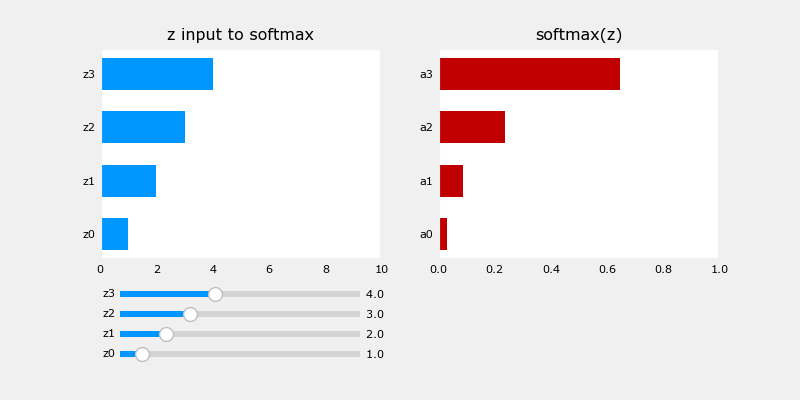

In [16]:
plt.close("all")
plt_softmax(my_softmax)

Al variar los valores de las z anteriores, hay que tener en cuenta algunas cosas:
* el exponencial en el numerador del softmax magnifica las pequeñas diferencias en los valores 
* los valores de salida suman uno
* el softmax abarca todas las salidas. Un cambio en "z0", por ejemplo, cambiará los valores de "a0" a "a3". Compare esto con otras activaciones como ReLU o Sigmoid que tienen una sola entrada y una sola salida.

## Cost
<center> <img  src="./images/C2_W2_SoftMaxCost.png" width="400" />    <center/>

La función de pérdida asociada a Softmax, la pérdida de entropía cruzada, es:

$$ 
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{Si $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{Si $y=N$}
  \end{cases} \tag{3}
\end{equation}
$$

Donde y es la categoría objetivo para este ejemplo y $\mathbf{a}$ es la salida de una función softmax. En particular, los valores de $\mathbf{a}$ son probabilidades que suman uno.
>**Recordemos:** En este curso, la Pérdida es para un ejemplo mientras que el Coste cubre todos los ejemplos. 
 
 
Obsérvese que en (3), sólo la línea que corresponde al objetivo contribuye a la pérdida, las demás líneas son cero. Para escribir la ecuación de costes necesitamos una "función indicadora" que será 1 cuando el índice coincida con el objetivo y cero en caso contrario. 

$$ \mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{Si $y==n$}.\\
    0, & \text{De lo contrario,}.
  \end{cases} $$
Ahora el costo es:
\begin{align}
J(\mathbf{w},b) = - \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Donde $m$ es el número de ejemplos, $N$ es el número de salidas. Es la media de todas las pérdidas.


## Tensorflow
Este laboratorio discutirá dos formas de implementar la pérdida de entropía cruzada softmax en Tensorflow, el método "obvio" y el método "preferido". El primero es el más sencillo mientras que el segundo es más estable numéricamente.

Empecemos creando un conjunto de datos para entrenar un modelo de clasificación multiclase.

In [17]:
#  hacer un conjunto de datos por ejemplo
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)

### The *Obvious* organization

El modelo de abajo está implementado con el softmax como activación en la capa final Dense.
La función de pérdida se especifica por separado en la directiva `compile`. 

La función de pérdida es `SparseCategoricalCrossentropy`. Esta pérdida se describe en (3). En este modelo, el softmax tiene lugar en la última capa. La función de pérdida toma la salida del softmax que es un vector de probabilidades. 

In [18]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 3s 4ms/step - loss: 0.9502
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 0.4270
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 0.1771
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0974
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0593
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0527
Epoch 8/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0481
Epoch 9/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 10/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0423


Como el softmax está integrado en la capa de salida, la salida es un vector de probabilidades.

In [26]:
p_nonpreferred = model.predict(X_train)
print(p_nonpreferred [:2])
print("mayor valor", np.max(p_nonpreferred), "menor valor", np.min(p_nonpreferred))

[[5.91e-03 1.12e-03 9.73e-01 2.04e-02]
 [9.91e-01 8.75e-03 2.85e-05 2.68e-08]]
mayor valor 0.9999988 menor valor 1.1474717e-13


### Preferred <img align="Right" src="./images/C2_W2_softmax_accurate.png"  style=" width:400px; padding: 10px 20px ; ">
Recordando la conferencia, se pueden obtener resultados más estables y precisos si el softmax y la pérdida se combinan durante el entrenamiento.   Esto es posible gracias a la organización "preferida" que se muestra aquí.


In [20]:
x1 = 2.0 / 10000
print(f"{x1:.18f}")

0.000200000000000000


In [21]:
x2 = 1 + (1 / 10000) - (1 - 1 / 10000)
print(f"{x2:.18f}")

0.000199999999999978


En la organización preferida, la capa final tiene una activación lineal. Por razones históricas, las salidas de esta forma se denominan *logits*. La función de pérdida tiene un argumento adicional: `from_logits = True`. Esto informa a la función de pérdida que la operación softmax debe ser incluida en el cálculo de la pérdida. Esto permite una implementación optimizada.

In [22]:
preferred_model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'linear')   #<-- Note
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 2s 4ms/step - loss: 0.9565
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 0.3817
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1956
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 0.1227
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 0.0910
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0747
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0645
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0582
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0532
Epoch 10/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0493


#### Manejo de los resultados
Observe que en el modelo preferido, las salidas no son probabilidades, sino que pueden ir desde números negativos grandes hasta números positivos grandes. La salida debe ser enviada a través de un softmax cuando se realiza una predicción que espera una probabilidad. 
Veamos las salidas del modelo preferido:

Manejo de los resultados
Observe que en el modelo preferido, las salidas no son probabilidades, sino que pueden ir desde números negativos grandes hasta números positivos grandes. La salida debe ser enviada a través de un softmax cuando se realiza una predicción que espera una probabilidad. 
Veamos las salidas del modelo preferido:

In [29]:
p_preferred = preferred_model.predict(X_train)
print(f"dos ejemplos de vectores de salida:\n {p_preferred[:2]}")
print("mayor valor", np.max(p_preferred), "menor valor", np.min(p_preferred))

dos ejemplos de vectores de salida:
 [[-1.05 -1.53  3.52 -0.2 ]
 [ 6.91  1.81 -1.91 -5.46]]
mayor valor 12.6281595 menor valor -10.525742


Las predicciones de salida no son probabilidades.
Si la salida deseada son probabilidades, la salida debe ser procesada por un [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax).

In [30]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
print(f"dos ejemplos de vectores de salida:\n {sm_preferred[:2]}")
print("mayor valor", np.max(sm_preferred), "menor valor", np.min(sm_preferred))

dos ejemplos de vectores de salida:
 [[9.88e-03 6.12e-03 9.61e-01 2.33e-02]
 [9.94e-01 6.03e-03 1.47e-04 4.19e-06]]
mayor valor 0.99999106 menor valor 7.2928535e-10


Para seleccionar la categoría más probable, no es necesario el softmax. Se puede encontrar el índice de la mayor salida utilizando [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [31]:
for i in range(5):
    print( f"{p_preferred[i]}, category: {np.argmax(p_preferred[i])}")

[-1.05 -1.53  3.52 -0.2 ], category: 2
[ 6.91  1.81 -1.91 -5.46], category: 0
[ 5.    1.6  -1.67 -4.41], category: 0
[-2.09  2.72 -4.12 -2.15], category: 1
[ 1.47 -2.55  5.91 -3.08], category: 2


## SparseCategorialCrossentropy o CategoricalCrossEntropy
Tensorflow tiene dos formatos potenciales para los valores objetivo y la selección de la pérdida define cuál se espera.
- SparseCategorialCrossentropy: espera que el objetivo sea un número entero correspondiente al índice. Por ejemplo, si hay 10 valores objetivo potenciales, y estaría entre 0 y 9. 
- CategoricalCrossEntropy: Espera que el valor objetivo de un ejemplo se codifique con un solo golpe, donde el valor en el índice objetivo es 1 mientras que las otras N-1 entradas son cero. Un ejemplo con 10 valores objetivo potenciales, donde el objetivo es 2 sería [0,0,1,0,0,0,0,0,0,0].


## ¡Enhorabuena!
En este laboratorio usted 
- Te has familiarizado con la función softmax y su uso en la regresión softmax y en las activaciones softmax en redes neuronales. 
- Aprendiste la construcción preferida del modelo en Tensorflow:
    - Sin activación en la capa final (igual que la activación lineal)
    - Función de pérdida SparseCategoricalCrossentropy
    - use from_logits=True
- Reconoció que a diferencia de ReLU y Sigmoid, el softmax abarca múltiples salidas.